Model for Thermal

In [2]:
import torch
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import cv2
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

def getRGBPart(img_path):
    # Load the YOLOv5 model
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    # Load the input image using PIL
    img = Image.open(img_path)
    # Filter out the detected banana objects based on confidence threshold
    h = np.array(img).shape[0]
    w = np.array(img).shape[1]
    # Perform object detection on the input image
    results = model(img)
    # print("results", results)
    # Get the detected objects and their coordinates
    labels = results.xyxyn[0][:, -1].cpu().numpy()
    scores = results.xyxyn[0][:, -2].cpu().numpy()
    boxes = results.xyxyn[0][:, :4].cpu().numpy()

    # Draw bounding boxes around the detected banana objects
    draw = ImageDraw.Draw(img)
    roi_img = None
    for box in boxes:
        x1, y1, x2, y2 = box
        roi_img = img.crop((x1*w, y1*h, x2*w, y2*h))
        draw.rectangle([x1*w, y1*h, x2*w, y2*h], outline='green', width=2)

    # Display the output image
    # img.show()
    # roi_img.show()
    if roi_img is None:
        return img
    return roi_img

def getIRPart(img_path):
    # Load image
    img = Image.open(img_path).convert('RGB')
    img_array = np.array(img)

    # Loop through pixels and set black if red value is not greater than 130
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            if img_array[i,j,0] <= 130:  # red channel is the first channel (index 0)
                img_array[i,j] = [0, 0, 0]  # set pixel to black
            else:
                img_array[i,j] = [255, 255, 255]  # set pixel to white
    # img_bw = Image.fromarray(img_array)
    # Find bounding box of non-black pixels
    coords = np.argwhere(img_array > 0)
    x_min = np.min(coords[:, 1])
    y_min = np.min(coords[:, 0])
    x_max = np.max(coords[:, 1])
    y_max = np.max(coords[:, 0])
    # Draw bounding box on original RGB image
    draw = ImageDraw.Draw(img)
    draw.rectangle([x_min, y_min, x_max, y_max], outline='green', width=2)
    
    # Crop image to bounding box
    img_cropped = img.crop((x_min, y_min, x_max+1, y_max+1))
    # img_cropped.show()
    
    # Return cropped image with bounding box drawn on original RGB image
    # img.show()
    if img_cropped is None or len(np.array(img_cropped) ) == 0 or np.array(img_cropped).shape[1] == 0 or np.array(img_cropped).shape[0] == 0:
        return img
    
    return img_cropped


def getObj(path1, path2, debug = 0):
    # Load the YOLOv5 model
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    # Load the input image using PIL
    img = Image.open(path1)
    img2 = Image.open(path2)
    # Filter out the detected banana objects based on confidence threshold

    # Draw bounding boxes around the detected banana objects
    draw = ImageDraw.Draw(img)
    dim1 = np.array(img).shape
    dim2 = np.array(img2).shape
    img = img.crop((dim1[1]*.23, dim1[0]*.4, dim1[1]*.82, dim1[0]*.98)).resize((dim2[1], dim2[0]))
    h = np.array(img).shape[0]
    w = np.array(img).shape[1]
    if debug:
        img.show()
        img2.show()
    # Perform object detection on the input image
    img1s, img2s = [], []
    for idx, augmentation in enumerate(augmentations):
        img_aug = augmentation(img)
        results = model(img_aug)
        img_aug2 = augmentation(img2)
        # print("results", results)
        # Get the detected objects and their coordinates
        labels = results.xyxyn[0][:, -1].cpu().numpy()
        scores = results.xyxyn[0][:, -2].cpu().numpy()
        boxes = results.xyxyn[0][:, :4].cpu().numpy()

        for box in boxes:
            x1, y1, x2, y2 = box
            if debug:
                draw = ImageDraw.Draw(img_aug)
                draw.rectangle([x1*w, y1*h, x2*w, y2*h], outline='green', width=2)
                img_aug.show()
            img_aug = img_aug.crop((x1*w, y1*h, x2*w, y2*h))
            img_aug2 = img_aug2.crop((x1*w, y1*h, x2*w, y2*h))
            break

        # Display the output image
        if debug:
            img_aug.show()
            img_aug2.show()
        img1s.append(img_aug)
        img2s.append(img_aug2)
    return img1s, img2s
# Define the augmentations
augmentations = [
    lambda img: img.rotate(90),
    lambda img: img.rotate(180),
    lambda img: img.rotate(270),
    lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
    lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
    lambda img: img, 
]

Model for Thermal

In [6]:
import os
import numpy as np
import keras
from PIL import Image
from keras.applications import VGG16
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Load pre-trained CNN model
model = VGG16(weights='imagenet', include_top=False)

# Define image directory and size
img_dir1 = "./Data/Train/RGB"
img_dir2 = "./Data/Train/IR"
img_size = (224, 224)

# Load and preprocess images
img_paths = []
labels = []
features = []
for folder in os.listdir(img_dir1):
    folder_path1 = os.path.join(img_dir1, folder)
    folder_path2 = os.path.join(img_dir2, folder)
    if folder != '.DS_Store':
        for img_file in os.listdir(folder_path1):
            if img_file != '.DS_Store':
                path1 = os.path.join(folder_path1, img_file)
                path2 = os.path.join(folder_path2, img_file.replace('VL.jpg', 'IR.jpg'))
                img1s, img2s = getObj(path1, path2)
                for i, img in enumerate(img1s):
                    img = img1s[i]
                    img = img.resize(img_size)
                    img_arr = np.array(img)
                    img_arr = np.expand_dims(img_arr, axis=0)
                    img_arr = keras.applications.vgg16.preprocess_input(img_arr)
                    # Extract features using pre-trained CNN
                    features.append(model.predict(img_arr).ravel())
                    labels.append(folder)
                
# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

X_train, X_test, y_train, y_test

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# Train SVM classifier
svm = SVC(kernel='linear', C=1, probability=True)
svm.fit(X_train, y_train)

# Evaluate SVM classifier
y_pred = svm.predict(X_test)
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred))

Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 262ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 203ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 272ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 304ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 303ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 271ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 273ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 310ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 312ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 291ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 308ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 386ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 368ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 366ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 302ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 365ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 263ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 332ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 358ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 343ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 328ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 276ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 242ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 273ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 274ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 265ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 276ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 206ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 206ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 297ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 327ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 248ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 264ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 244ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 320ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 249ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 253ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 282ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 261ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 258ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 150ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 270ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 268ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 260ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 260ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 351ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 257ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 266ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 206ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 248ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 257ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 295ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 290ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 274ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 207ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 195ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 211ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 260ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 247ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 207ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 250ms/step
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 286ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 245ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 265ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 245ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 245ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 247ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 244ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 247ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 300ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 274ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 259ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 265ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 253ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 257ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 131ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 130ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 256ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 185ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 280ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 257ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 261ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 266ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 202ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 209ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 133ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 204ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 271ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 331ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 317ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 266ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 266ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 294ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 245ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 263ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 254ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 329ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 271ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 249ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 284ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 312ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 306ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 384ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 290ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 298ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 319ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 318ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 293ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 294ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 330ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 326ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 291ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 262ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 247ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 206ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 138ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 209ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 216ms/step
Confusion matrix:
[[  0   0   0   0]
 [ 16 113   0  15]
 [199  43   0   4]
 [  0   0   0   0]]
Classification report:
              precision    recall  f1-score   support

  Fresh Ripe       0.00      0.00      0.00         0
   Over Ripe       0.72      0.78      0.75       144
        Ripe       0.00      0.00      0.00       246
      Unripe       0.00      0.00      0.00         0

    accuracy                           0.29       390
   macro avg       0.18      0.20      0.19       390
weighted avg       0.27      0.29      0.28       390



Model for RGB

In [5]:
import os
import numpy as np
import keras
from PIL import Image
from keras.applications import VGG16
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Load pre-trained CNN model
model = VGG16(weights='imagenet', include_top=False)

# Define image directory and size
img_dir = "./Data/Train/RGB"
img_size = (224, 224)

# Load and preprocess images
img_paths = []
labels = []
for folder in os.listdir(img_dir):
    folder_path = os.path.join(img_dir, folder)
    if folder != '.DS_Store':   
        for img_file in os.listdir(folder_path):
            if img_file != '.DS_Store':
                img_path = os.path.join(folder_path, img_file)
                img_paths.append(img_path)
                labels.append(folder)
        
features = []
for path in img_paths:
    img = getRGBPart(path)
    for idx, augmentation in enumerate(augmentations):
        img_aug = augmentation(img)
        img_aug = img_aug.resize(img_size)
        img_arr = np.array(img_aug)
        img_arr = np.expand_dims(img_arr, axis=0)
        img_arr = keras.applications.vgg16.preprocess_input(img_arr)    
        # Extract features using pre-trained CNN
        features.append(model.predict(img_arr).ravel())
        labels.append(folder)

# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# Train SVM classifier
svm = SVC(kernel='linear', C=1, probability=True)
svm.fit(X_train, y_train)

# Evaluate SVM classifier
y_pred = svm.predict(X_test)
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred))


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 201ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 184ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 133ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 211ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 204ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 321ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 245ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 211ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 134ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 211ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 310ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 242ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 259ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 206ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 202ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 131ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 205ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 131ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 141ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 207ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 209ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 295ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 298ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 211ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 315ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 309ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 275ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 262ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 312ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 131ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 296ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 298ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 270ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 253ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 1s 535ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 316ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 260ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 325ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 289ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 311ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 262ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 292ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 255ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 264ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 263ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 393ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 360ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 256ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 311ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 338ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 247ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 260ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 334ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 397ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 377ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 304ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 176ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 346ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 259ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 274ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 337ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 271ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 253ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 270ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 244ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 262ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 254ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 255ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 295ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 255ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 269ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 254ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 249ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 249ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 248ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 245ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 255ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 244ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 297ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 275ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 328ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 278ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 254ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 250ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 247ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 252ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 285ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 258ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 292ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 288ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 287ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 291ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 331ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 292ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 312ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 282ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 253ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 248ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 254ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 255ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 244ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 282ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 244ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 252ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 201ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 247ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 151ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 252ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 244ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 332ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 267ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 258ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 259ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 286ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 279ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 247ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 281ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 312ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 398ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 265ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 320ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 282ms/step


ValueError: Found input variables with inconsistent numbers of samples: [1950, 2275]

Fusion Model

In [7]:
import os
import numpy as np
import keras
from PIL import Image
from keras.applications import VGG16
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Load pre-trained CNN model
model = VGG16(weights='imagenet', include_top=False)

# Define image directory and size
img_dir1 = "./Data/Train/RGB"
img_dir2 = "./Data/Train/IR"
img_size = (224, 224)

# Load and preprocess images
labels = []
features_thermal = []
features_rgb = []
for folder in os.listdir(img_dir1):
    folder_path1 = os.path.join(img_dir1, folder)
    folder_path2 = os.path.join(img_dir2, folder)
    if folder != '.DS_Store':
        for img_file in os.listdir(folder_path1):
            if img_file != '.DS_Store':
                path1 = os.path.join(folder_path1, img_file)
                path2 = os.path.join(folder_path2, img_file.replace('VL.jpg', 'IR.jpg'))
                print(path2)
                img1s, img2s = getObj(path1, path2)
                for i, img in enumerate(img1s):
                    img_aug1 = img1s[i]
                    img_aug2 = img2s[i]
                    
                    img_aug1 = img_aug1.resize(img_size)
                    img_arr1 = np.array(img_aug1)
                    img_arr1 = np.expand_dims(img_arr1, axis=0)
                    img_arr1 = keras.applications.vgg16.preprocess_input(img_arr1)
                
                    img_aug2 = img_aug2.resize(img_size)
                    img_arr2 = np.array(img_aug2)
                    img_arr2 = np.expand_dims(img_arr1, axis=0)
                    img_arr2 = keras.applications.vgg16.preprocess_input(img_arr1)
                
                    # Extract features using pre-trained CNN
                    features_rgb.append(model.predict(img_arr1).ravel())
                    features_thermal.append(model.predict(img_arr2).ravel())
                    labels.append(folder)

                
# Convert features and labels to numpy arrays
features_thermal = np.array(features_thermal)
features_rgb = np.array(features_rgb)
labels = np.array(labels)

features = np.hstack((features_thermal, features_rgb))

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# Train SVM classifier
svm = SVC(kernel='linear', C=1, probability=True)
svm.fit(X_train, y_train)

# Evaluate SVM classifier
y_pred = svm.predict(X_test)
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred))


./Data/Train/IR/Fresh Ripe/IR_00512_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 290ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00267_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 244ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00528_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00279_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00304_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00275_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00524_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_09593_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_09544_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00298_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00286_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step
./Data/Train/IR/Fresh Ripe/IR_00294_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_09546_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00296_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 276ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00288_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 211ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00284_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 143ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00502_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 278ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00510_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 274ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00269_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_09591_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step
./Data/Train/IR/Fresh Ripe/IR_00277_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00526_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00306_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00265_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00280_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 130ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00292_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 244ms/step
./Data/Train/IR/Fresh Ripe/IR_09542_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00302_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00261_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 245ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_09595_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00522_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00273_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00514_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00518_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 242ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00506_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step
./Data/Train/IR/Fresh Ripe/IR_09589_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00520_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00271_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 249ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00263_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00300_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 281ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00504_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 261ms/step
./Data/Train/IR/Fresh Ripe/IR_00516_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 264ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00508_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00290_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 250ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00282_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00287_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00299_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00295_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step
./Data/Train/IR/Fresh Ripe/IR_09545_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00305_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 207ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00529_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00278_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00266_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 257ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_09592_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00274_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00525_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00513_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00276_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00527_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 242ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_09590_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00268_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00264_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 213ms/step
./Data/Train/IR/Fresh Ripe/IR_00503_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 137ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00511_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00289_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00297_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 249ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00285_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00515_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 263ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00507_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00519_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00303_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00523_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00272_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_09594_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_09543_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00281_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step
./Data/Train/IR/Fresh Ripe/IR_00293_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00291_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00283_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Fresh Ripe/IR_00505_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step
./Data/Train/IR/Fresh Ripe/IR_00509_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00517_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step
./Data/Train/IR/Fresh Ripe/IR_09596_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 236ms/step
./Data/Train/IR/Fresh Ripe/IR_00521_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00270_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 215ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00301_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Fresh Ripe/IR_00262_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 251ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09771_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 265ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_09819_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09807_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09815_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 242ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_00536_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09823_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00555_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00547_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00076_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 252ms/step
./Data/Train/IR/Unripe/IR_00068_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00015_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step
./Data/Train/IR/Unripe/IR_09790_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00064_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 250ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00019_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 260ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00007_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 247ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09782_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step
./Data/Train/IR/Unripe/IR_00052_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00031_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 252ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00040_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 246ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00023_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 202ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00078_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step
./Data/Train/IR/Unripe/IR_09780_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00005_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00066_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step
./Data/Train/IR/Unripe/IR_09792_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step
./Data/Train/IR/Unripe/IR_00017_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00074_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00009_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00021_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step
./Data/Train/IR/Unripe/IR_00042_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00033_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00050_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09817_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09809_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09805_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 292ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_09773_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00538_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step
./Data/Train/IR/Unripe/IR_00545_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09821_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00557_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00534_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00549_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 242ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00037_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00029_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00054_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00025_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00058_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00046_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09796_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00013_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09788_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step
./Data/Train/IR/Unripe/IR_00070_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09784_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00001_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 260ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_00062_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00553_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00530_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_00541_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step
./Data/Train/IR/Unripe/IR_09801_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09769_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09777_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09813_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00543_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00532_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00551_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09811_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step
./Data/Train/IR/Unripe/IR_00081_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_09779_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09775_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 139ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09803_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00039_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 140ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00044_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00027_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00056_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 245ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00035_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 255ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00048_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09798_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00060_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00003_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 210ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09786_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00072_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step
./Data/Train/IR/Unripe/IR_00011_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09794_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00030_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00053_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 211ms/step
./Data/Train/IR/Unripe/IR_00022_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00041_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00014_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step
./Data/Train/IR/Unripe/IR_09791_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 244ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_00069_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 245ms/step
./Data/Train/IR/Unripe/IR_00077_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step
./Data/Train/IR/Unripe/IR_00006_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09783_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00018_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00065_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00554_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09822_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00537_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00546_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09806_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09818_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09770_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09814_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00544_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00539_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00548_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00535_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00556_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step
./Data/Train/IR/Unripe/IR_09820_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09808_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09816_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09772_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step
./Data/Train/IR/Unripe/IR_09804_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00043_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00020_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00051_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 242ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00032_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 226ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00067_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09781_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00004_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step
./Data/Train/IR/Unripe/IR_00079_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00008_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 267ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00075_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09793_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00016_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 239ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09776_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09800_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09812_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00531_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00552_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00540_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00071_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step
./Data/Train/IR/Unripe/IR_09789_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09797_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00012_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_00063_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09785_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 242ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00055_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00028_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00036_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 242ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00047_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00059_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00024_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00002_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09787_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 234ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00061_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09799_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00010_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09795_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 233ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_00073_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_00026_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00045_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step
./Data/Train/IR/Unripe/IR_00038_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00049_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00034_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 219ms/step
./Data/Train/IR/Unripe/IR_00057_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 241ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Unripe/IR_09778_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00080_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 227ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09810_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09802_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_09774_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 140ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00542_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00550_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Unripe/IR_00533_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09612_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09581_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09831_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 256ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Over Ripe/IR_09556_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step
./Data/Train/IR/Over Ripe/IR_09558_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09610_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09833_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09583_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09825_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09837_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Over Ripe/IR_09829_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_00083_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09835_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09827_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 190ms/step
./Data/Train/IR/Over Ripe/IR_09608_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 138ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09576_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09557_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 223ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09830_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09832_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 221ms/step
./Data/Train/IR/Over Ripe/IR_09582_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09611_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09559_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09607_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_00082_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 228ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09824_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09828_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 273ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09836_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 260ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09575_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 258ms/step
./Data/Train/IR/Over Ripe/IR_09609_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 225ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Over Ripe/IR_09834_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 240ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09584_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 285ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09826_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 248ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Over Ripe/IR_09838_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 272ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09600_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 255ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09548_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 273ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Ripe/IR_09560_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09572_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 224ms/step
./Data/Train/IR/Ripe/IR_09554_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09570_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09562_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09602_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 217ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09578_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 231ms/step
./Data/Train/IR/Ripe/IR_09566_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 218ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09574_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 212ms/step
./Data/Train/IR/Ripe/IR_09550_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 230ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09587_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09599_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09606_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 238ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09597_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09585_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 220ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09604_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Ripe/IR_09568_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09564_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 235ms/step
./Data/Train/IR/Ripe/IR_09552_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 245ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Ripe/IR_09561_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 243ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Ripe/IR_09573_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 225ms/step
./Data/Train/IR/Ripe/IR_09549_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 221ms/step
./Data/Train/IR/Ripe/IR_09580_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.
1/1 [==============================] - 0s 222ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09601_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 342ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Ripe/IR_09603_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09571_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 328ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Ripe/IR_09563_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09555_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 232ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09598_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 256ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09586_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 250ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU



./Data/Train/IR/Ripe/IR_09551_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 278ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09567_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 229ms/step
./Data/Train/IR/Ripe/IR_09579_IR.jpg


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 267ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09553_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 250ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09569_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 214ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09577_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 236ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09565_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 237ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09605_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 216ms/step


Using cache found in /Users/mohitkumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 


./Data/Train/IR/Ripe/IR_09588_IR.jpg
requirements: /Users/mohitkumar/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1/1 [==============================] - 0s 320ms/step
Confusion matrix:
[[  0   0   0   0]
 [ 24 108   0  12]
 [215  27   0   4]
 [  0   0   0   0]]
Classification report:
              precision    recall  f1-score   support

  Fresh Ripe       0.00      0.00      0.00         0
   Over Ripe       0.80      0.75      0.77       144
        Ripe       0.00      0.00      0.00       246
      Unripe       0.00      0.00      0.00         0

    accuracy                           0.28       390
   macro avg       0.20      0.19      0.19       390
weighted avg       0.30      0.28      0.29       390



/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-5-7 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


100%|██████████| 14.1M/14.1M [00:00<00:00, 208MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


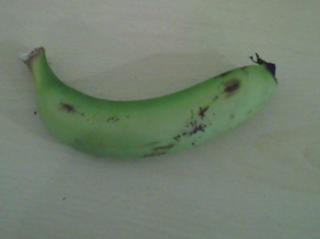

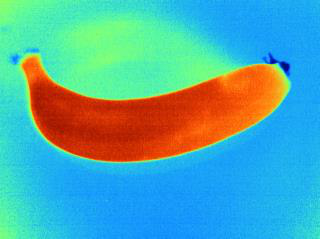

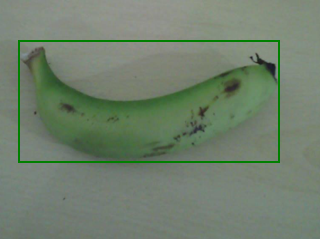

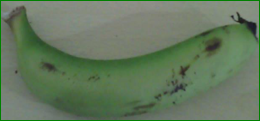

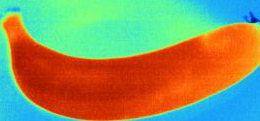

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


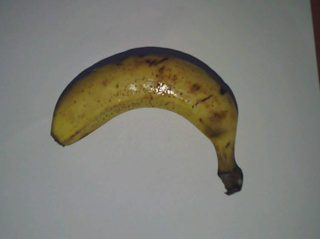

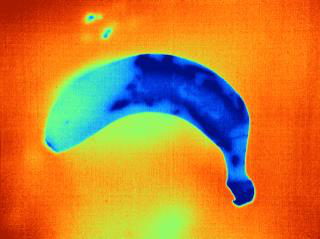

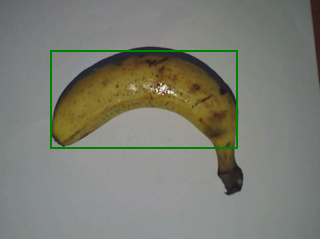

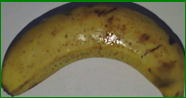

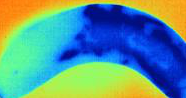

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


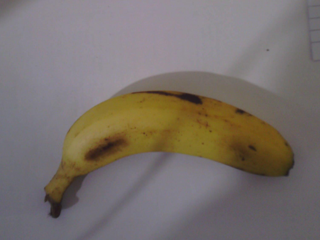

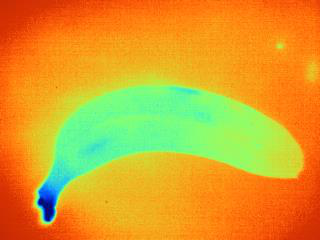

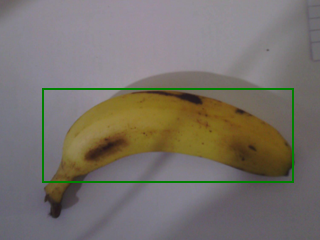

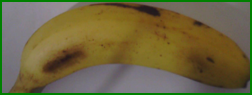

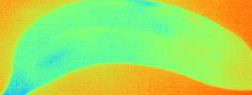

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


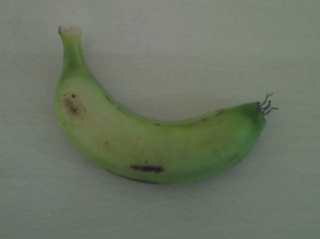

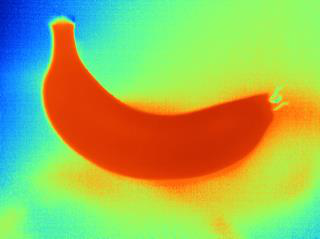

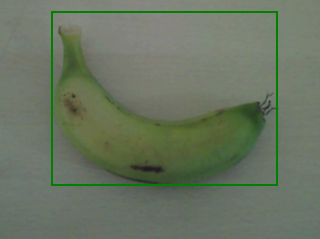

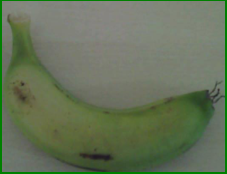

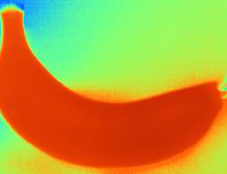

In [ ]:
import torch
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import cv2
import matplotlib.pyplot as plt


# Define image directory and size
img_dir1 = "/content/drive/MyDrive/Banana Dataset RGB"
img_dir2 = "/content/drive/MyDrive/Banana Dataset IR"
img_size = (224, 224)

# Load the YOLOv5 model
features_rgb = []
features_thermal = []
label = []
nos = 3
for folder in os.listdir(img_dir1):
    folder_path1 = os.path.join(img_dir1, folder)
    folder_path2 = os.path.join(img_dir2, folder)
    if folder != '.DS_Store':
        for img_file in os.listdir(folder_path1):
            if folder != '.DS_Store':
                if (folder == 'Unripe' and nos >= 0):
                    nos -= 1
                    continue
                if (folder == 'Over Ripe'):
                    img_file = "IR_09827_VL.jpg"
                features_rgb = []
                features_thermal = []
                label = []
                path1 = os.path.join(folder_path1, img_file)
                path2 = os.path.join(folder_path2, img_file.replace('VL.jpg', 'IR.jpg'))
                img1, img2 = getObj(path1, path2, 1)
                # img_arr1 = np.array(img1)
                # img_arr1 = np.expand_dims(img_arr1, axis=0)
                # img_arr1 = keras.applications.vgg16.preprocess_input(img_arr1)
                # img_arr2 = np.array(img2)
                # img_arr2 = np.expand_dims(img_arr1, axis=0)
                # img_arr2 = keras.applications.vgg16.preprocess_input(img_arr1)
                # features_rgb.append(model.predict(img_arr1).ravel())
                # features_thermal.append(model.predict(img_arr2).ravel())
                # labels.append(folder)
                img1 = img1.resize(img_size)
                img2 = img2.resize(img_size)
                # img_arr1 = np.array(img1)
                # img_arr1 = np.expand_dims(img_arr1, axis=0)
                # img_arr1 = keras.applications.vgg16.preprocess_input(img_arr1)
                # img_arr2 = np.array(img2)
                # img_arr2 = np.expand_dims(img_arr1, axis=0)
                # img_arr2 = keras.applications.vgg16.preprocess_input(img_arr1)
                # features_rgb.append(model.predict(img_arr1).ravel())
                # features_thermal.append(model.predict(img_arr2).ravel())
                # features = np.hstack((features_thermal, features_rgb))
                # y_pred = svm.predict(features)
                # print('========')
                # print(y_pred)
                # print('========')
                break

